In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay,f1_score, 
                             recall_score, precision_score, balanced_accuracy_score, RocCurveDisplay)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier



In [12]:
#setting options to be able to see whole text in dataframe columns
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('max_colwidth',800)

In [13]:
#Reading train and test data
train=pd.read_csv('../datasets/train_clean.csv')
test=pd.read_csv('../datasets/test_clean.csv')
train.shape, test.shape

((7611, 10), (2537, 10))

In [14]:
#Creating X and y, train and test
X_train=train['title_st_lemma']
y_train=train['subreddit']
X_test=test['title_st_lemma']
y_test=test['subreddit']

Beginning with Naive Bayes model.

**Model 1: Naive-Bayes with cvec**

In [11]:
pipe_nb=Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

nb_param={
    'cvec__stop_words':[None,'english'],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'cvec__max_df':[1.0,0.9,0.8],
    'cvec__min_df':[0.0,0.1],
    'cvec__max_features':[7000,10_000, 15_000,18_000]
}

gs_nb=GridSearchCV(pipe_nb,
                  param_grid=nb_param,
                  cv=5,
                  n_jobs=-1)



In [12]:
gs_nb.fit(X_train,y_train);

In [13]:
best_score1=gs_nb.best_score_
print(f'Best Score: {gs_nb.best_score_}')
print(f'Best Params: {gs_nb.best_params_}')

Best Score: 0.9240595580856995
Best Params: {'cvec__max_df': 1.0, 'cvec__max_features': 18000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}


In [14]:
#Calculating accuracy score
training_accuracy1=gs_nb.score(X_train, y_train)
print(f'Training_score: {training_accuracy1}')
testing_accuracy1=gs_nb.score(X_test, y_test)
print(f'Testing score: {testing_accuracy1}')

#Calculating F1 scores
pred_train1=gs_nb.predict(X_train)
pred1=gs_nb.predict(X_test)
f1score_train1=f1_score(y_train,pred_train1)
f1score_test1=f1_score(y_test,pred1)
print(f'F1 Train score: {f1score_train1}')
print(f'F1 Test score: {f1score_test1}')

Training_score: 0.9558533701221915
Testing score: 0.92313756405203
F1 Train score: 0.9561815336463224
F1 Test score: 0.9239766081871345


In [15]:
#Defining function to store the model evaluation metrics
eval_df=pd.DataFrame(columns=['model','training_accuracy','testing_accuracy','best_score','f1score_train','f1score_test','comments'])

def model_eval (model_no, training_accuracy, testing_accuracy, best_score, f1score_train, f1score_test, comment):
    
    eval_df.loc[len(eval_df.index)]=[ model_no, training_accuracy, testing_accuracy, best_score, f1score_train, f1score_test, comment]
          
    return eval_df
          

In [16]:
#Saving model metrics
model_eval(1,training_accuracy1,testing_accuracy1, best_score1,f1score_train1, f1score_test1, 'cvec_nb')

,model,training_accuracy,testing_accuracy,best_score,f1score_train,f1score_test,comments
0,1,0.955853,0.923138,0.92406,0.956182,0.923977,cvec_nb


This model has decent accuracy and f1-score, it seems to be a bit overfit though.

**Model 2: Naive-Bayes with tvec**

To try and improve score, using engineering, science and similar words as the stop words in vectorizer for following models and trying tvec instead of cvec.

In [17]:
pipe_nb2=Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

nb_param2={
    'tvec__stop_words':[['engineering','engineers', 'askscience','askengineers','science']],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__max_df':[1.0,0.9,0.8],
    'tvec__min_df':[0.0,0.1],
    'tvec__max_features':[7000,10_000, 15_000,18_000]
}

gs_nb2=GridSearchCV(pipe_nb2,
                  param_grid=nb_param2,
                  cv=5,
                  n_jobs=-1)

gs_nb2.fit(X_train,y_train);

In [8]:
best_score2=gs_nb2.best_score_
print(f'Best Score: {gs_nb2.best_score_}')
print(f'Best Params: {gs_nb2.best_params_}')

Best Score: 0.9210374779012651
Best Params: {'tvec__max_df': 1.0, 'tvec__max_features': 15000, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['engineering', 'engineers', 'askscience', 'askengineers', 'science']}


In [19]:
#Calculating accuracy score
training_accuracy2=gs_nb2.score(X_train, y_train)
testing_accuracy2=gs_nb2.score(X_test, y_test)

#Calculating F1 scores
pred_train2=gs_nb2.predict(X_train)
pred2=gs_nb2.predict(X_test)
f1score_train2=f1_score(y_train,pred_train2)
f1score_test2=f1_score(y_test,pred2)

#Saving metrics
model_eval(2,training_accuracy2,testing_accuracy2, best_score2, f1score_train2, f1score_test2, 'tvec_nb')

,model,training_accuracy,testing_accuracy,best_score,f1score_train,f1score_test,comments
0,1,0.955853,0.923138,0.924060,0.956182,0.923977,cvec_nb
1,2,0.953094,0.921955,0.921037,0.953582,0.922837,tvec_nb


Using tvec instead of cvec did not make much difference, also addition of engineering and science words in stop words did not make much difference. The scores are comparable to model1.  
Trying Random Forest and other models to see if we can find a less overfit model with better score.

**Model 3 Random Forest with tvec**

In [22]:
pipe_rf=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_param={
    'tvec__stop_words':[['engineering','engineers', 'askscience','askengineers','science']],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__max_features':[7000,10_000],
    'rf__n_estimators': [100,200],
    'rf__max_depth':[None,3,4,5],
    'rf__max_features':['sqrt', 0.8],
    'rf__min_samples_split':[2,3],
      }


gs_rf=GridSearchCV(pipe_rf,
                  param_grid=rf_param,
                  cv=5,
                  n_jobs=-1)


In [ ]:
gs_rf.fit(X_train,y_train);

In [21]:
best_score3=gs_rf.best_score_
print(f'Best Score: {gs_rf.best_score_}')
print(f'Best Params: {gs_rf.best_params_}')

Best Score: 0.904218453274064
Best Params: {'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__min_samples_split': 2, 'rf__n_estimators': 200, 'tvec__max_features': 10000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': ['engineering', 'engineers', 'askscience', 'askengineers', 'science']}


In [22]:
#Calculating accuracy score
training_accuracy3=gs_rf.score(X_train, y_train)
testing_accuracy3=gs_rf.score(X_test, y_test)

#Calculating F1 scores
pred_train3=gs_rf.predict(X_train)
pred3=gs_rf.predict(X_test)
f1score_train3=f1_score(y_train,pred_train3)
f1score_test3=f1_score(y_test,pred3)

#Saving metrics
model_eval(3,training_accuracy3,testing_accuracy3, best_score3, f1score_train3, f1score_test3, 'tvec_rf')

,model,training_accuracy,testing_accuracy,best_score,f1score_train,f1score_test,comments
0,1,0.955853,0.923138,0.924060,0.956182,0.923977,cvec_nb
1,2,0.953094,0.921955,0.921037,0.953582,0.922837,tvec_nb
2,3,0.999869,0.906188,0.904218,0.999869,0.907465,tvec_rf


This model (Random Forest) seems to be a lot more overfit than previous models.

**Model 4 AdaBoost with tvec**

In [25]:
pipe_ada=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)),
])

ada_param={
    'tvec__stop_words':[['engineering','engineers', 'askscience','askengineers','science']],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__max_df':[1.0,0.9],
    'tvec__min_df':[0.0,0.1],
    'tvec__max_features':[7000,10_000],
    'ada__n_estimators': [50,100],
    'ada__base_estimator__max_depth':[1,3,4],
    'ada__base_estimator__min_samples_split':[2,3,4],
    'ada__learning_rate':[0.9,1.0,1.1],
       
          
    }


gs_ada=GridSearchCV(pipe_ada,
                  param_grid=ada_param,
                  cv=5,
                  n_jobs=-1)


gs_ada.fit(X_train,y_train);

In [26]:
best_score4=gs_ada.best_score_
print(f'Best Score: {gs_ada.best_score_}')
print(f'Best Params: {gs_ada.best_params_}')

Best Score: 0.8838543127153253
Best Params: {'ada__base_estimator__max_depth': 1, 'ada__base_estimator__min_samples_split': 2, 'ada__learning_rate': 1.0, 'ada__n_estimators': 100, 'tvec__max_df': 1.0, 'tvec__max_features': 7000, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': ['engineering', 'engineers', 'askscience', 'askengineers', 'science']}


In [27]:
#Calculating accuracy score
training_accuracy4=gs_ada.score(X_train, y_train)
testing_accuracy4=gs_ada.score(X_test, y_test)

#Calculating F1 scores
pred_train4=gs_ada.predict(X_train)
pred4=gs_ada.predict(X_test)
f1score_train4=f1_score(y_train,pred_train4)
f1score_test4=f1_score(y_test,pred4)

#Saving metrics
model_eval(4,training_accuracy4,testing_accuracy4, best_score4, f1score_train4, f1score_test4, 'tvec_ada')

,model,training_accuracy,testing_accuracy,best_score,f1score_train,f1score_test,comments
0,1,0.955853,0.923138,0.924060,0.956182,0.923977,cvec_nb
1,2,0.953094,0.921955,0.921037,0.953582,0.922837,tvec_nb
2,3,0.999869,0.906188,0.904218,0.999869,0.907465,tvec_rf
3,4,0.906451,0.886480,0.883854,0.908295,0.890076,tvec_ada


This model (AdaBoost) is not that overfit but has lower scores compared to Naive Bayes.

**Model 5: Logistic Regression**

In [94]:
pipe_logreg=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42)),
])

logreg_param={
    'tvec__stop_words':[['engineering','engineers', 'askscience','askengineers','science']],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__max_df':[1.0,0.9],
    'tvec__min_df':[0.0,0.1],
    'tvec__max_features':[7000,10_000,18_000],
    'lr__C':[1.0,0.1,0.5,5,10]
           
    }


gs_logreg=GridSearchCV(pipe_logreg,
                  param_grid=logreg_param,
                  cv=5,
                  n_jobs=-1)


gs_logreg.fit(X_train,y_train);

In [95]:
best_score5=gs_logreg.best_score_
print(f'Best Score: {gs_logreg.best_score_}')
print(f'Best Params: {gs_logreg.best_params_}')

Best Score: 0.9243217662076801
Best Params: {'lr__C': 1.0, 'tvec__max_df': 1.0, 'tvec__max_features': 10000, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['engineering', 'engineers', 'askscience', 'askengineers', 'science']}


In [31]:
#Calculating accuracy score
training_accuracy5=gs_logreg.score(X_train, y_train)
testing_accuracy5=gs_logreg.score(X_test, y_test)

#Calculating F1 scores
pred_train5=gs_logreg.predict(X_train)
pred5=gs_logreg.predict(X_test)
f1score_train5=f1_score(y_train,pred_train5)
f1score_test5=f1_score(y_test,pred5)

#Saving metrics
model_eval(5,training_accuracy5,testing_accuracy5, best_score5, f1score_train5, f1score_test5, 'tvec_logreg')

,model,training_accuracy,testing_accuracy,best_score,f1score_train,f1score_test,comments
0,1,0.955853,0.923138,0.924060,0.956182,0.923977,cvec_nb
1,2,0.953094,0.921955,0.921037,0.953582,0.922837,tvec_nb
2,3,0.999869,0.906188,0.904218,0.999869,0.907465,tvec_rf
3,4,0.906451,0.886480,0.883854,0.908295,0.890076,tvec_ada
4,5,0.961109,0.917619,0.924322,0.961767,0.919831,tvec_logreg


Logistic Regression has a slightly better training score but is a little more overfit than Naive-Bayes.

**Model 6: K-nearest neighbors**

In [ ]:
pipe_knn=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('knn', KNeighborsClassifier()),
])

knn_param={
    'tvec__stop_words':[['engineering','engineers', 'askscience','askengineers','science']],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__max_df':[1.0,0.9],
    'tvec__min_df':[0.0,0.1],
    'tvec__max_features':[7000,10_000,18_000,28_000],
    'knn__n_neighbors':[5,10,15],
    'knn__weights': ['uniform','distance'], 
    'knn__p':[1,2]
    }


gs_knn=GridSearchCV(pipe_knn,
                  param_grid=knn_param,
                  cv=5,
                  n_jobs=-1)


gs_knn.fit(X_train,y_train);


In [195]:
best_score6=gs_knn.best_score_
print(f'Best Score: {gs_knn.best_score_}')
print(f'Best Params: {gs_knn.best_params_}')

Best Score: 0.8935766344004286
Best Params: {'knn__n_neighbors': 15, 'knn__p': 2, 'knn__weights': 'uniform', 'tvec__max_df': 1.0, 'tvec__max_features': 18000, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['engineering', 'engineers', 'askscience', 'askengineers', 'science']}


In [271]:
#Calculating accuracy score
training_accuracy6=gs_knn.score(X_train, y_train)
testing_accuracy6=gs_knn.score(X_test, y_test)

#Calculating F1 scores
pred_train6=gs_knn.predict(X_train)
pred6=gs_knn.predict(X_test)
f1score_train6=f1_score(y_train,pred_train6)
f1score_test6=f1_score(y_test,pred6)

#Saving metrics
model_eval(6,training_accuracy6,testing_accuracy6, best_score6, f1score_train6, f1score_test6, 'tvec_knn')

,model,training_accuracy,testing_accuracy,best_score,f1score_train,f1score_test,comments
0,1,0.955853,0.923138,0.924060,0.956182,0.923977,cvec_nb
1,2,0.953094,0.921955,0.921037,0.953582,0.922837,tvec_nb
2,3,0.999869,0.906188,0.904218,0.999869,0.907465,tvec_rf
3,4,0.906451,0.886480,0.883854,0.908295,0.890076,tvec_ada
4,5,0.961109,0.917619,0.924322,0.961767,0.919831,tvec_logreg
5,6,0.912101,0.886086,0.893577,0.913911,0.888889,tvec_knn


K-nearest neighbors is less overfit but has low testing score.

### Production Model

Considering f1-score as our evaluation metrics, summary of model performance:
1. Naive Bayes with cvec: high test score (0.92) with a difference between train and test score of about 0.032 
2. Naive Bayes with Tfidf: very comparable to Naive Bayes with cvec, test score(0.92) with a train and test difference of 0.031
3. Random Forest: very overfit model with 0.99 training score and 0.9 testing score
4. Logistic Regression: high train score but slightly more overfit than Naive Bayes
5. Ada Boost: Not overfit (difference between train and test is 0.01) but low scores (0.9)
6. K-nearest neighbors: Less overfit but lower score compared to Naive Bayes (0.91)   


Since we are building a prediction model, selecting Naive Bayes with Tfidf (Model 2) as our production model as it has the highest accuracy score (0.92(92%)) and f1 score (training: 0.95, testing: 0.92) along with being one of the less overfit models.  
This model meets the criteria of accuracy >85% and f1-score >0.85 stated in the problem statement.

**Evaluating the model further**

In [24]:
gs_nb2.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=15000, min_df=0.0,
                                 ngram_range=(1, 2),
                                 stop_words=['engineering', 'engineers',
                                             'askscience', 'askengineers',
                                             'science'])),
                ('nb', MultinomialNB())])

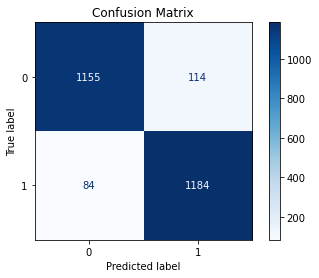

In [24]:
#Help from lesson 4.03
#Confusion  matrix
ConfusionMatrixDisplay.from_estimator(gs_nb2,X_test,y_test,cmap='Blues',values_format='d')
plt.title('Confusion Matrix')
plt.savefig('../images/confusion_matrix.png')

In [129]:
tn,fp,fn,tp=confusion_matrix(y_test, pred2).ravel()
print(f'True positive: {tp}\nFalse positive: {fp}\nTrue negative: {tn}\nFalse negative:{fn}')

True positive: 1184
False positive: 114
True negative: 1155
False negative:84


The confusion matrix and the output above show the number of true and false, positives and negatives. We have 114 false positives and 84 false negatives out of total of 2537 predictions.

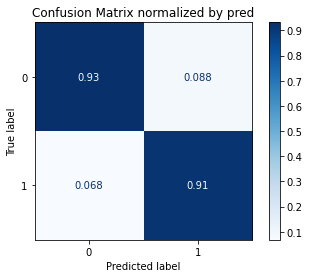

In [25]:
ConfusionMatrixDisplay.from_estimator(gs_nb2,X_test,y_test,cmap='Blues',normalize='pred')
plt.title('Confusion Matrix normalized by pred')
plt.savefig('../images/confusion_matrix_norm_by_pred.png');

In [297]:
#Specificity
spec=tn/(tn+fp)
print(f'Specificity: {spec}')

print(f"Recall score/Sensitivity: {recall_score(y_test,pred2,pos_label=1)}")
print(f"Precision score: {precision_score(y_test,pred2,pos_label=1)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test,pred2)}")

Specificity: 0.9101654846335697
Recall score/Sensitivity: 0.9337539432176656
Precision score: 0.9121725731895224
Balanced accuracy: 0.9219597139256177


The model is predicitng 91% of 0s (Engineering) correctly (specificity) and 93% of 1s (Science) correctly (sensitivity).   
Also, 93% of predicted 0s are correct but 91% of predicted 1s are correct (from the normalized confusion matrix display).
It has more false positives than false negatives, and higher sensitivity meaning that it is more inclined to give false positives and predict a query/submission belonging to class- AskScience (value 1).
The Balanced accuracy is 0.92 which gives good confidence in calssification accuracy for both the classes.


In [287]:
#Misclassification
print(f'Misclassification: {(fp+fn)/(tp+fp+tn+fn)}')

Misclassification: 0.0780449349625542


This model has 7.8% misclassification.

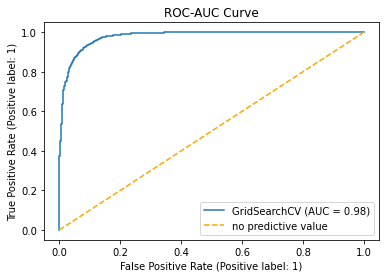

In [23]:
#Looking ROC-AUC curve
RocCurveDisplay.from_estimator(gs_nb2,X_test,y_test)

# add 'worst case scenario' line
plt.plot([0,1],[0,1],label='no predictive value', linestyle='--',color='orange')

# add a legend
plt.legend();
plt.title('ROC-AUC Curve')
plt.savefig('../images/roc_auc.png');

The ROC curve looks good indicating we have a good seapration between the two classes.

There is a small concern about the misclassification, if the question goes to the other ctaegory during panel discussion, so the model needs to be tuned to reduce both false positives and negatives. Following section on Miscalssification EDA takes ann initial look at the text and it may be possible to clean out text or do some more feature engineering to bring unique features/identifiers to the two categories.

**Creating predictions**

In [29]:
#Storing probabilities
prob2=pd.DataFrame(gs_nb2.predict_proba(X_test),
                   columns=('p(Engineering)','p(Science)'))
prob2;


In [30]:
#Creating predictions dataframe and saving it

predictions=pd.DataFrame()
predictions['title']=test['title']
predictions['selftext']=test['selftext']
predictions['title_st_lemma']=test['title_st_lemma']
predictions=pd.concat([predictions,prob2], axis=1)
predictions['predictions']=pred2
predictions['true_values']=y_test.values
predictions.head(1)
#mapping 0 to engineering and 1 to science
predictions['predictions']=predictions['predictions'].map({1:'AskScience',0:'AskEngineers'})
predictions['true_values']=predictions['true_values'].map({1:'AskScience',0:'AskEngineers'})

predictions.to_csv('../datasets/predictions.csv')
predictions.head(1)

,title,selftext,title_st_lemma,p(Engineering),p(Science),predictions,true_values
0,I need some help with a calculation of airflow through two pressurised tanks full of air.,"┌───────┐ ┌───────┐\n │ p1 │ │ p2 │\n │ │ │ │\n │ │ X │ │\n │ ├──┼───┤ │\n │ ├──┴───┤ │\n └───────┘ └────────┘\n\nI need some help with a problem that is giving me inconsistent results.\n\nI have two reservoirs at ambient temperature both full of air. Number 1 is a 70 litres full container at 10 bar, number two is a 13 m³ container at 1 bar. There is a pipe of a certain section A connecting them with a valve X in the middle. Both containers are at the same level so we can assume the pressure drop due to height is negligible.\n\nI need the container on the left to discharge completely in a certain amount of time, so I need to dimension correctly the size of the connecting pipe.\n\nI've used t...",need help calculation airflow pressurise tank air p p x need help problem inconsistent result reservoir ambient temperature air number litre container bar number m container bar pipe certain section connect valve x middle container level assume pressure drop height negligible need container left discharge completely certain time need dimension correctly size connect pipe use bernoullis principle hagenpoiseuille equation darcyweisbach equation try inconsistent result flow speed apply incompressible fluid air compressible headache help,0.718282,0.281718,AskEngineers,AskEngineers


The predictions dataframe and csv file contains the predictions, probabilities, true values as well as the text for review if needed.

**Feature importance insight**

Although the goal of this project is to get a good predictive model. It will be great to get some insight into the words/features that are important for this classification. Using Logistic Regression model to get some inferences.

In [97]:
print(f"Balanced accuracy: {balanced_accuracy_score(y_test,pred5)}")

Balanced accuracy: 0.9176302535840088


In [122]:
#help from : https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
#getting logistic regression coefficients
coef=gs_logreg.best_estimator_.named_steps['lr'].coef_
coef=coef.ravel()

In [123]:
#Getting features form tvec
features=gs_logreg.best_estimator_.named_steps['tvec'].get_feature_names_out()

In [124]:
#creating a dataframe to store features and coefficients
feature_imp=pd.DataFrame([(features[i],coef[i]) for i in range(0,len(coef))])
feature_imp.columns=['feature','coef']

#Top most important feature for positive classification(AskScience)
feature_imp.sort_values(by='coef',ascending=False).head()

,feature,coef
2477,earth,3.201303
2593,electron,2.702043
319,animal,2.530262
4124,human,2.519838
3835,happen,2.495041


The table above shows top 5 important words for classification of a submission as AskScience. The coefficient can be interpreted as: e.g. a unit increase in occurance of word 'earth' will make it e^3.2 times likely to be classified as an AskScience post. 

In [125]:
#Top most important feature for negative classification (AskEngineers)
feature_imp.sort_values(by='coef').head()

,feature,coef
2704,engineer,-7.335212
4581,job,-5.031740
9472,want,-4.624706
2156,design,-4.235624
1517,company,-4.044728


The table above shows top 5 important words for classification of a submission as AskEngineers.
An occurance of these words in a post of opposite category may increase the chances of it being misclassified.

**Misclassification EDA**

In [38]:
#creating dataframe for misclassified predictions
misclassified=predictions[predictions['predictions']!=predictions['true_values']]
print(f'Misclassified count: {misclassified.shape[0]}/{test.shape[0]}')

Misclassified count: 198/2537


In [132]:
misclassified.sample(random_state=42)

,title,selftext,title_st_lemma,p(Engineering),p(Science),predictions,true_values
814,How long the space elevator would need to be to not collapse on itself?,Keeping in mind that each meter of the link (so excluding the ground base and space station) will probably need to be big enough to hold a lift compartment and all necessary communication/power links so it will be at least few hundred kg. \nElevator would probably need to be long enough (and big enough on the space end part) so the centrifugal force will alleviate some part of mass.,long space elevator need collapse mind meter link exclude ground base space station probably need big hold lift compartment necessary communicationpower link kg elevator probably need long big space end centrifugal force alleviate mass,0.535047,0.464953,AskEngineers,AskScience


Above table output shows an exmple of submission that was actually posted in AskScience subreddit but was classifed as AskEngineers. If we look at the text, the text actually conatins physics/engineering related material that might be suitable for AskEngineers as well. So while our model is predicting incorrectly when we compared with true values, some of the posts may be suitable for both subreddits.

In [51]:
misclassified.describe()

,p(Engineering),p(Science)
count,198.000000,198.000000
mean,0.453228,0.546772
std,0.177365,0.177365
min,0.065012,0.137748
25%,0.339447,0.423915
50%,0.452498,0.547502
75%,0.576085,0.660553
max,0.862252,0.934988


It is interesting to note that about 50% of misclassifications (between 25% and 75% - inter quartile) are within 0.42-0.66 p(Science) range. This could be kept in mind to improve the model performance in future.

**Most frequent words in misclassified submissions**

In [34]:
cvec=CountVectorizer()
misclass_text_cvec=cvec.fit_transform(misclassified['title_st_lemma'])
misclass_text_df=pd.DataFrame(misclass_text_cvec.todense(),columns=cvec.get_feature_names_out())
misclass_text_df['true_subreddit']=misclassified['true_values'].values
misclass_text_df.head(1);

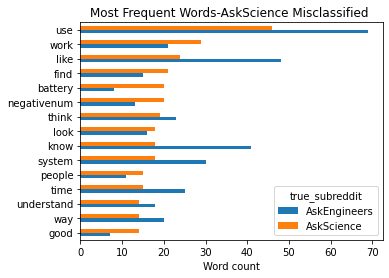

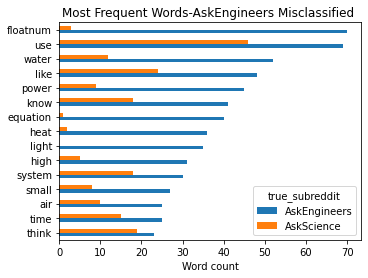

In [127]:
#Most frequent words in misclassified AskScience posts
misclass_text_df.groupby('true_subreddit').sum().T.sort_values('AskScience',ascending=True).tail(15).plot(kind='barh')
plt.title('Most Frequent Words-AskScience Misclassified ')
plt.xlabel('Word count')
plt.subplots_adjust(left=0.2);
plt.savefig('../images/freq_words_sc_misclass.png');
plt.show()

#Most frequent words in subreddit AskEngineers
misclass_text_df.groupby('true_subreddit').sum().T.sort_values('AskEngineers',ascending=True).tail(15).plot(kind='barh')
plt.title('Most Frequent Words-AskEngineers Misclassified ')
plt.xlabel('Word count')
plt.subplots_adjust(left=0.2);
plt.savefig('../images/freq_words_engg_misclass.png');
plt.show()

The figures above show the most frequent words in misclassified posts for the two subreddits. A lot of words seem not specific like - use, work, like, find etc. It would be interesting to see how the model performs when we remove these words. These could be the next steps in an attempt to reduce false positives and false negatives.